# Quantum Ising Phase Transition
### Carsten Bauer, Katharine Hyatt

## Introduction

In this tutorial we will consider a simple quantum mechanical system of spins sitting on a chain. Here, *quantum mechanical*, despite its pompous sound, simply means that our Hamiltonian matrix will have a non-trivial (i.e. non-diagonal) matrix structure.

We will then ask a couple of basic questions,

* What is the ground state of the system?
* What happens if we turn on a transverse magnetic field?
* Are there any phase transitions?

To get answers to the questions, we will solve the time-independent Schrödinger equation

$$H|\psi\rangle = E |\psi\rangle$$

in Julia by means of exact diagonalization of the Hamiltonian.

## Transverse field quantum Ising chain

Let's start out by defining our system. The Hamiltonian is given by

$$\mathcal{H} = -\sum_{\langle i, j \rangle} \hat{\sigma}_i^z \otimes \hat{\sigma}_j^z - h\sum_i \hat{\sigma}_i^x$$

Here, $\hat{\sigma}^z$ and $\hat{\sigma}^x$ are two of the three [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices), representing our quantum spins, $\langle i, j \rangle$ indicates that only neighboring spins talk to each other, and $h$ is the amplitude of the magnetic field. 

In [1]:
σᶻ = [1 0; 0 -1] # \sigma <TAB> followed by \^z <TAB>

2×2 Matrix{Int64}:
 1   0
 0  -1

In [2]:
σˣ = [0 1; 1 0]

2×2 Matrix{Int64}:
 0  1
 1  0

Labeling the eigensates of $\sigma^z$ as $|\downarrow\rangle$ and $|\uparrow\rangle$, we interpret them as a spin pointing down or up (in $z$-direction), respectively.

Clearly, since being purely off-diagonal, the effect of $\sigma^x$ on such a single spin is to flip it:

$$\hat{\sigma}^x\left| \downarrow \right\rangle = \left| \uparrow \right\rangle$$

$$\hat{\sigma}^x\left| \uparrow \right\rangle = \left| \downarrow \right\rangle$$

The idea behind the Hamiltonian above is as follows:

* The first term is diagonal in the $\sigma^z$ eigenbasis. If there is no magnetic field, $h=0$, our quantum model reduces to the well-known classical [Ising model](https://en.wikipedia.org/wiki/Ising_model) (diagonal = trivial matrix structure -> classical). In this case, we have a **finite temperature phase transition** from a paramagnetic ($T>T_c$) phase, where the spins are **disordered by thermal fluctuations**, to a ferromagnetic phase ($T<T_c$), where they all point into the $z$ direction and, consequently, a ferromagnetic ground state at $T=0$.

* Since this would be boring, we want to add quantum complications to this picture by making $H$ non-diagonal. To this end, we expose the quantum spins to a transverse magnetic field $h$ in $x$ direction in the second term. Now, since $\sigma^z$ and $\sigma^x$ do not commute (check `σˣ*σᶻ - σᶻ*σˣ` yourself), there is no common eigenbasis of the first and the second term and our Hamiltonian has a non-trivial matrix structure (It's quantum!). If there was *only the second term* the system would, again, be trivial, as it would be diagonal in the eigenbasis of $\sigma^x$: the quantum spins want to be in an eigenstate of $\sigma^x$, i.e. align to the magnetic field.

* We can see that if we have both terms we have a competition between the spins wanting to point in the $z$ direction (first term) and at the same time being disturbed by the transverse magnetic field. We say that the magnetic field term adds **quantum fluctuations** to the system.

Let us explore the physics of this interplay.

## Building the Hamiltonian matrix

We will choose the $\sigma^z$ eigenbasis as our computation basis.

To build up our Hamiltonian matrix we need to take the kronecker product (tensor product) of spin matrices. Fortunately, Julia has a built-in function for this.

In [3]:
kron(σᶻ,σᶻ) # this is the matrix of the tensor product σᶻᵢ⊗ σᶻⱼ (⊗ = \otimes <TAB>)

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

Let's be fancy (cause we can!) and make this look a bit cooler.

In [4]:
⊗(x,y) = kron(x,y)

⊗ (generic function with 1 method)

In [5]:
σᶻ ⊗ σᶻ

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

### Explicit 4-site Hamiltonian

Imagine our spin chain consists of four sites. Writing out identity matrices (which were left implicit in $H$ above) explicitly, our Hamiltonian reads

$$\mathcal{H}_4 = -\hat{\sigma}_1^z \hat{\sigma}_2^z \hat{I}_3 \hat{I}_4 - \hat{I}_1 \hat{\sigma}_2^z \hat{\sigma}_3^z \hat{I}_4 - \hat{I}_1 \hat{I}_2 \hat{\sigma}_3^z \hat{\sigma}_4^z - h\left(\hat{\sigma}_1^x\hat{I}_2 \hat{I}_3\hat{I}_4 + \hat{I}_1 \hat{\sigma}_2^x \hat{I}_3\hat{I}_4 +\hat{I}_1 \hat{I}_2 \hat{\sigma}_3^x\hat{I}_4 + \hat{I}_1 \hat{I}_2 \hat{I}_3 \hat{\sigma}_4^x\right)$$

(Note that we are considering *open* boundary conditions here - the spin on site 4 doesn't interact with the one on the first site. For *periodic* boundary conditions we'd have to add a term $- \hat{\sigma}^z_1 \hat{I}_2 \hat{I}_3 \hat{\sigma}_4^z$.)

Translating this expression to Julia is super easy. After defining the identity matrix

In [6]:
id = [1 0; 0 1] # identity matrix

2×2 Matrix{Int64}:
 1  0
 0  1

we can simply write

In [7]:
h = 1
H = - σᶻ⊗σᶻ⊗id⊗id - id⊗σᶻ⊗σᶻ⊗id - id⊗id⊗σᶻ⊗σᶻ
H -= h*(σˣ⊗id⊗id⊗id + id⊗σˣ⊗id⊗id + id⊗id⊗σˣ⊗id + id⊗id⊗id⊗σˣ)

16×16 Matrix{Int64}:
 -3  -1  -1   0  -1   0   0   0  -1   0   0   0   0   0   0   0
 -1  -1   0  -1   0  -1   0   0   0  -1   0   0   0   0   0   0
 -1   0   1  -1   0   0  -1   0   0   0  -1   0   0   0   0   0
  0  -1  -1  -1   0   0   0  -1   0   0   0  -1   0   0   0   0
 -1   0   0   0   1  -1  -1   0   0   0   0   0  -1   0   0   0
  0  -1   0   0  -1   3   0  -1   0   0   0   0   0  -1   0   0
  0   0  -1   0  -1   0   1  -1   0   0   0   0   0   0  -1   0
  0   0   0  -1   0  -1  -1  -1   0   0   0   0   0   0   0  -1
 -1   0   0   0   0   0   0   0  -1  -1  -1   0  -1   0   0   0
  0  -1   0   0   0   0   0   0  -1   1   0  -1   0  -1   0   0
  0   0  -1   0   0   0   0   0  -1   0   3  -1   0   0  -1   0
  0   0   0  -1   0   0   0   0   0  -1  -1   1   0   0   0  -1
  0   0   0   0  -1   0   0   0  -1   0   0   0  -1  -1  -1   0
  0   0   0   0   0  -1   0   0   0  -1   0   0  -1   1   0  -1
  0   0   0   0   0   0  -1   0   0   0  -1   0  -1   0  -1  -1
  0   0   0   0   0

There it is.

As nice as it is to write those tensor products explicitly, we certainly wouldn't want to write out all the terms for, say, 100 sites.

Let's define a function that iteratively does the job for us.

In [8]:
function TransverseFieldIsing(;N,h)
    id = [1 0; 0 1]
    σˣ = [0 1; 1 0]
    σᶻ = [1 0; 0 -1]
    
    # vector of operators: [σᶻ, σᶻ, id, ...]
    first_term_ops = fill(id, N)
    first_term_ops[1] = σᶻ
    first_term_ops[2] = σᶻ
    
    # vector of operators: [σˣ, id, ...]
    second_term_ops = fill(id, N)
    second_term_ops[1] = σˣ
    
    H = zeros(Int, 2^N, 2^N)
    for i in 1:N-1
        # tensor multiply all operators
        H -= foldl(⊗, first_term_ops)
        # cyclic shift the operators
        first_term_ops = circshift(first_term_ops,1)
    end
    
    for i in 1:N
        H -= h*foldl(⊗, second_term_ops)
        second_term_ops = circshift(second_term_ops,1)
    end
    H
end

TransverseFieldIsing (generic function with 1 method)

In [9]:
TransverseFieldIsing(N=8, h=1)

256×256 Matrix{Int64}:
 -7  -1  -1   0  -1   0   0   0  -1  …   0   0   0   0   0   0   0   0   0
 -1  -5   0  -1   0  -1   0   0   0      0   0   0   0   0   0   0   0   0
 -1   0  -3  -1   0   0  -1   0   0      0   0   0   0   0   0   0   0   0
  0  -1  -1  -5   0   0   0  -1   0      0   0   0   0   0   0   0   0   0
 -1   0   0   0  -3  -1  -1   0   0      0   0   0   0   0   0   0   0   0
  0  -1   0   0  -1  -1   0  -1   0  …   0   0   0   0   0   0   0   0   0
  0   0  -1   0  -1   0  -3  -1   0      0   0   0   0   0   0   0   0   0
  0   0   0  -1   0  -1  -1  -5   0      0   0   0   0   0   0   0   0   0
 -1   0   0   0   0   0   0   0  -3      0   0   0   0   0   0   0   0   0
  0  -1   0   0   0   0   0   0  -1      0   0   0   0   0   0   0   0   0
  0   0  -1   0   0   0   0   0  -1  …   0   0   0   0   0   0   0   0   0
  0   0   0  -1   0   0   0   0   0      0   0   0   0   0   0   0   0   0
  0   0   0   0  -1   0   0   0  -1      0   0   0   0   0   0   0   0   0
  

### Many-particle basis

Beyond a single spin, we have to think how to encode our basis states.

We make the arbitrary choice:
$0 = \text{false} = \downarrow$ and $1 = \text{true} = \uparrow$

This way, our many-spin basis states have nice a binary representations and we can efficiently store them in a Julia `BitArray`.

Example: $|0010\rangle = |\text{false},\text{false},\text{true},\text{false}\rangle = |\downarrow\downarrow\uparrow\downarrow>$ is a basis state of a 4-site system

We construct the full basis by binary counting.

In [10]:
"""
Binary `BitArray` representation of the given integer `num`, padded to length `N`.
"""
bit_rep(num::Integer, N::Integer) = BitArray(parse(Bool, i) for i in string(num, base=2, pad=N))

"""
    generate_basis(N::Integer) -> basis

Generates a basis (`Vector{BitArray}`) spanning the Hilbert space of `N` spins.
"""
function generate_basis(N::Integer)
    nstates = 2^N
    basis = Vector{BitArray{1}}(undef, nstates)
    for i in 0:nstates-1
        basis[i+1] = bit_rep(i, N)
    end
    return basis
end

generate_basis

In [11]:
generate_basis(4)

16-element Vector{BitVector}:
 [0, 0, 0, 0]
 [0, 0, 0, 1]
 [0, 0, 1, 0]
 [0, 0, 1, 1]
 [0, 1, 0, 0]
 [0, 1, 0, 1]
 [0, 1, 1, 0]
 [0, 1, 1, 1]
 [1, 0, 0, 0]
 [1, 0, 0, 1]
 [1, 0, 1, 0]
 [1, 0, 1, 1]
 [1, 1, 0, 0]
 [1, 1, 0, 1]
 [1, 1, 1, 0]
 [1, 1, 1, 1]

### Side remark: Iterative construction of $H$

It might not be obvious that this basis is indeed the basis underlying the Hamiltonian matrix constructed in `TransverseFieldIsing`. To convince ourselves that this is indeed the case, let's calculate the matrix elements of our Hamiltonian, $\langle \psi_1 | H | \psi_2 \rangle$, explicitly by applying $H$ to our basis states and utilizing their orthonormality, $\langle \psi_i | \psi_j \rangle = \sigma_{i,j}$.

In [12]:
using LinearAlgebra

function TransverseFieldIsing_explicit(; N::Integer, h::T=0) where T<:Real
    basis = generate_basis(N)
    H = zeros(T, 2^N, 2^N)
    bonds = zip(collect(1:N-1), collect(2:N))
    for (i, bstate) in enumerate(basis)
        # diagonal part
        diag_term = 0.
        for (site_i, site_j) in bonds
            if bstate[site_i] == bstate[site_j]
                diag_term -= 1
            else
                diag_term += 1
            end
        end
        H[i, i] = diag_term
        
        # off diagonal part
        for site in 1:N
            new_bstate = copy(bstate)
            # flip the bit on the site (that's what σˣ does)
            new_bstate[site] = !new_bstate[site]
            # find corresponding single basis state with unity overlap (orthonormality)
            new_i = findfirst(isequal(new_bstate), basis)
            H[i, new_i] = -h
        end
    end
    return H
end

TransverseFieldIsing_explicit (generic function with 1 method)

In [13]:
TransverseFieldIsing_explicit(N=4, h=1) ≈ TransverseFieldIsing(N=4, h=1)

true

### Full exact diagonalization

Alright. Let's solve the Schrödinger equation by diagonalizing $H$ for a system with $N=8$ and $h=1$.

In [14]:
basis = generate_basis(8)
H = TransverseFieldIsing(N=8, h=1)
vals, vecs = eigen(H)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
256-element Vector{Float64}:
 -9.837951447459423
 -9.468878009606213
 -8.74329948717107
 -8.37422604931787
 -8.054998024353269
 -7.685924586500059
 -7.427412901942413
 -7.058339464089192
 -6.960346064064938
 -6.881915778576781
 -6.591272626211728
 -6.512842340723582
 -6.437082904540967
  ⋮
  6.512842340723571
  6.591272626211724
  6.881915778576781
  6.960346064064936
  7.05833946408919
  7.427412901942394
  7.685924586500059
  8.054998024353267
  8.374226049317883
  8.74329948717109
  9.468878009606211
  9.837951447459421
vectors:
256×256 Matrix{Float64}:
 0.340927   -0.459362   -2.08167e-16  …  -1.14492e-16   0.00885459
 0.173416   -0.210059   -0.0826509        0.00480955   -0.0133586
 0.109265   -0.126567   -0.0600217       -0.00990677   -0.0214075
 0.135509   -0.123533   -0.182584         0.00219934    0.0121301
 0.101521   -0.116488   -0.0389137        0.0115529    -0.0195355
 0.0603592  -0.0541307  -0.0677375    … 

That's it. Here is our groundstate. 

In [15]:
groundstate = vecs[:,1];

The absolute square of this wave function is the probability of finding the system in a particular basis state.

In [16]:
abs2.(groundstate)

256-element Vector{Float64}:
 0.11623105759943102
 0.03007315081450274
 0.011938898954891404
 0.01836268922781092
 0.010306563749646383
 0.0036432311839577408
 0.005695810419718903
 0.014593393364127462
 0.009913022568277504
 0.002835013679521534
 0.0013498376280201623
 0.002581028347123994
 0.004405195883727786
 ⋮
 0.00258102834712394
 0.0013498376280201257
 0.0028350136795214534
 0.009913022568276907
 0.014593393364127013
 0.0056958104197187415
 0.003643231183957627
 0.010306563749645782
 0.018362689227810047
 0.011938898954890675
 0.03007315081450098
 0.11623105759941803

It's instructive to look at the extremal cases $h=0$ and $h>>1$.

In [17]:
H = TransverseFieldIsing(N=8, h=0)
vals, vecs = eigen(H)
groundstate = vecs[:,1]
abs2.(groundstate)

256-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

As we can see, for $h=0$ the system is (with probability one) in the first basis state, where all spins point in $-z$ direction.

In [18]:
basis[1]

8-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0

On the other hand, for $h=100$, the system occupies all basis states with approximately equal probability (maximal superposition) - corresponding to eigenstates of $\sigma^x$, i.e. alignment to the magnetic field.

In [19]:
H = TransverseFieldIsing(N=8, h=100)
vals, vecs = eigen(H)
groundstate = vecs[:,1]
abs2.(groundstate)

256-element Vector{Float64}:
 0.004045339592145769
 0.004004987329714091
 0.0039651372057858
 0.004004886702523796
 0.003965038080465971
 0.003925683101156526
 0.0039649384545287995
 0.004004886199391182
 0.003965037585486789
 0.003925487314471254
 0.003886621577798374
 0.003925584959072647
 0.003964838836732747
 ⋮
 0.0039255849590726765
 0.0038866215777984495
 0.003925487314471335
 0.0039650375854868814
 0.004004886199391226
 0.003964938454528879
 0.003925683101156629
 0.003965038080466085
 0.004004886702523868
 0.003965137205785895
 0.004004987329714185
 0.004045339592145804

# Are you a magnet or what?

Let's vary $h$ and see what happens. Since we're looking at quantum magnets we will compute the overall magnetization, defined by

$$M = \frac{1}{N}\sum_{i} \sigma^z_i$$
where $\sigma^z_i$ is the value of the spin on site $i$ when we measure.

In [20]:
function magnetization(state, basis)
    M = 0.
    for (i, bstate) in enumerate(basis)
        bstate_M = 0.
        for spin in bstate
            bstate_M += (state[i]^2 * (spin ? 1 : -1))/length(bstate)
        end
        @assert abs(bstate_M) <= 1
        M += abs(bstate_M)
    end
    return M
end

magnetization (generic function with 1 method)

In [21]:
magnetization(groundstate, basis)

0.2748106008973599

Now we would like to examine the effects of $h$. We will:

1. Find a variety of $h$ to look at.
2. For each, compute the lowest energy eigenvector (groundstate) of the corresponding Hamiltonian.
3. For each groundstate, compute the overall magnetization $M$.
4. Plot $M(h)$ for a variety of system sizes, and see if anything cool happens.

[0.9999000299900034, 0.9992275301410243, 0.9941108617216778, 0.9591866669399158, 0.8202546347014362, 0.6435606282913411, 0.5535510608967722, 0.519342103385646, 0.5069557253424016, 0.5024999687505857]
[0.9999619162456799, 0.9996970723690668, 0.9974830646467239, 0.9773789215903044, 0.8354226216616809, 0.6201747242734786, 0.5387766199872497, 0.5132785827294044, 0.5046859825477755, 0.5016729165356772]
[0.9999687399231213, 0.9997574390110391, 0.998090665590265, 0.9834625621009825, 0.830992649384176, 0.5178560625397849, 0.41874605456604996, 0.38991363075606433, 0.380266696515714, 0.37688129681508376]
[0.9999724979921556, 0.9997869479334597, 0.9983421299947642, 0.986444161502084, 0.8497025365410158, 0.5004140817498625, 0.41087379409708047, 0.38702986409349655, 0.3792256725176009, 0.3765066095836438]
[0.9999749983061567, 0.9998063320776901, 0.9984949630645026, 0.9879234155671198, 0.8614091153977388, 0.44447348069374415, 0.3496735716584181, 0.3249989019717578, 0.31689733445178836, 0.31406880494

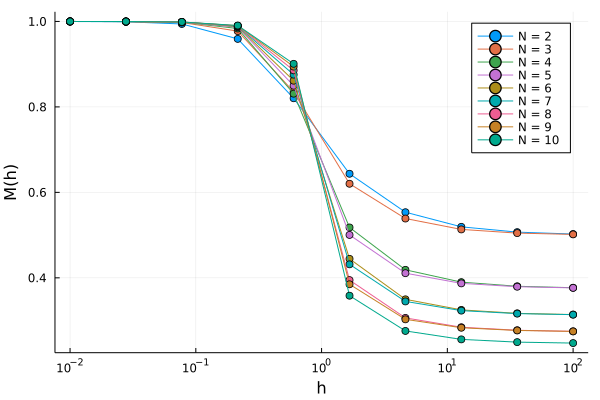

In [22]:
using Plots
hs = 10 .^ range(-2., stop=2., length=10)
Ns = 2:10
p = plot()
for N in Ns
    M = zeros(length(hs))
    for (i,h) in enumerate(hs)
        basis = generate_basis(N)
        H = TransverseFieldIsing(N=N, h=h)
        vals, vecs = eigen(H)
        groundstate = vecs[:,1]
        M[i] = magnetization(groundstate, basis)
    end
    plot!(p, hs, M, xscale=:log10, marker=:circle, label="N = $N",
        xlab="h", ylab="M(h)")
    println(M)
end
p

**This looks like a phase transition!**

For small $h$, the magnetization is unity, corresponding to a ferromagnetic state. By increasing the magnetic field $h$ we have a competition between the two terms in the Hamiltonian and eventually the system becomes paramagnetic with $M\approx0$. Our plot suggests that this change of state happens around $h\sim1$, which is in good agreement with the exact solution $h=1$.

It is crucial to realize, that in our calculation we are inspecting the ground state of the system. Since $T=0$, it is purely quantum fluctuations that drive the transition: a **quantum phase transition**! This is to be compared to increasing temperature in the classical Ising model, where it's thermal fluctuations that cause a classical phase transition from a ferromagnetic to a paramagnetic state. For this reason, the state that we observe at high magnetic field strengths is called a **quantum paramagnet**.

## Hilbert space is a big space

So far, we have only inspected chains of length $N\leq10$. As we see in our plot above, there are rather strong finite-size effects on the magnetization. To extract a numerical estimate for the critical magnetic field strength $h_c$ of the transition we would have to consider much larger systems until we observe convergence as a function of $N$. Although this is clearly beyond the scope of this tutorial, let us at least pave the way.

Our calculation, in its current form, doesn't scale. The reason for this is simple, **Hilbert space is a big place!**

The number of basis states, and therefore the number of dimensions, grows **exponentially** with system size.

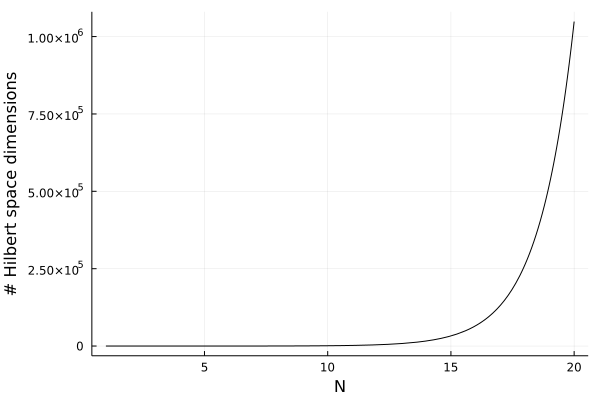

In [23]:
plot(N -> 2^N, 1, 20, legend=false, color=:black, xlab="N", ylab="# Hilbert space dimensions")

Our Hamiltonian matrix therefore will become huge(!) and is not going to fit into memory (apart from the fact that diagonalization would take forever).

In [24]:
using Test
@test_throws OutOfMemoryError TransverseFieldIsing(N=20, h=1)

Test Passed
  Expression: TransverseFieldIsing(N = 20, h = 1)
      Thrown: OutOfMemoryError

So, what can we do about it? The answer is, **sparsity**.

Let's inspect the Hamiltonian a bit more closely.

In [25]:
H = TransverseFieldIsing(N=10, h=1)

1024×1024 Matrix{Int64}:
 -9  -1  -1   0  -1   0   0   0  -1  …   0   0   0   0   0   0   0   0   0
 -1  -7   0  -1   0  -1   0   0   0      0   0   0   0   0   0   0   0   0
 -1   0  -5  -1   0   0  -1   0   0      0   0   0   0   0   0   0   0   0
  0  -1  -1  -7   0   0   0  -1   0      0   0   0   0   0   0   0   0   0
 -1   0   0   0  -5  -1  -1   0   0      0   0   0   0   0   0   0   0   0
  0  -1   0   0  -1  -3   0  -1   0  …   0   0   0   0   0   0   0   0   0
  0   0  -1   0  -1   0  -5  -1   0      0   0   0   0   0   0   0   0   0
  0   0   0  -1   0  -1  -1  -7   0      0   0   0   0   0   0   0   0   0
 -1   0   0   0   0   0   0   0  -5      0   0   0   0   0   0   0   0   0
  0  -1   0   0   0   0   0   0  -1      0   0   0   0   0   0   0   0   0
  0   0  -1   0   0   0   0   0  -1  …   0   0   0   0   0   0   0   0   0
  0   0   0  -1   0   0   0   0   0      0   0   0   0   0   0   0   0   0
  0   0   0   0  -1   0   0   0  -1      0   0   0   0   0   0   0   0   0


Noticably, there are a lot of zeros. How does this depend on $N$?

Let's plot the sparsity, i.e. ratio of zero entries.

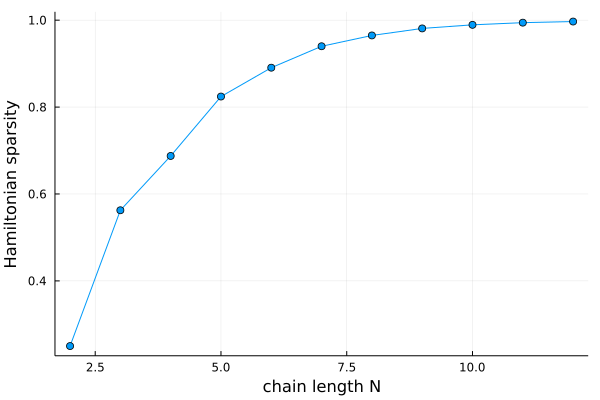

In [26]:
sparsity(x) = count(isequal(0), x)/length(x)

Ns = 2:12
sparsities = Float64[]
for N in Ns
    H = TransverseFieldIsing(N=N, h=1)
    push!(sparsities, sparsity(H))
end
plot(Ns, sparsities, legend=false, xlab="chain length N", ylab="Hamiltonian sparsity", marker=:circle)

For $N\gtrsim10$ almost all entries are zero! We should get rid of those and store $H$ as a sparse matrix.

### Building the sparse Hamiltonian

Generally, we can bring a dense matrix into a sparse matrix format using the function `sparse`.

In [27]:
using SparseArrays
H = TransverseFieldIsing(N=4,h=1)
H |> sparse

16×16 SparseMatrixCSC{Int64, Int64} with 80 stored entries:
⢟⣵⠑⢄⠑⢄⠀⠀
⠑⢄⢟⣵⠀⠀⠑⢄
⠑⢄⠀⠀⢟⣵⠑⢄
⠀⠀⠑⢄⠑⢄⢟⣵

Note that in this format, only the 80 non-zero entries are stored (rather than 256 elements).

So, how do we have to modify our function `TransverseFieldIsing` to only keep track of non-zero elements during the Hamiltonian construction?

It turns out it is as simple as initializing our Hamiltonian, identity, and pauli matrices as sparse matrices!

In [28]:
function TransverseFieldIsing_sparse(;N,h)
    id = [1 0; 0 1] |> sparse
    σˣ = [0 1; 1 0] |> sparse
    σᶻ = [1 0; 0 -1] |> sparse
    
    first_term_ops = fill(id, N)
    first_term_ops[1] = σᶻ
    first_term_ops[2] = σᶻ
    
    second_term_ops = fill(id, N)
    second_term_ops[1] = σˣ
    
    H = spzeros(Int, 2^N, 2^N) # note the spzeros instead of zeros here
    for i in 1:N-1
        H -= foldl(⊗, first_term_ops)
        first_term_ops = circshift(first_term_ops,1)
    end
    
    for i in 1:N
        H -= h*foldl(⊗, second_term_ops)
        second_term_ops = circshift(second_term_ops,1)
    end
    H
end

TransverseFieldIsing_sparse (generic function with 1 method)

We should check that apart from the new type `SparseMatrixCSC` this is still the same Hamiltonian.

In [29]:
H = TransverseFieldIsing_sparse(N=10, h=1);

In [30]:
H_dense = TransverseFieldIsing(N=10, h=1)
H ≈ H_dense

true

Great. But is it really faster?

In [31]:
@time TransverseFieldIsing(N=10,h=1);
@time TransverseFieldIsing_sparse(N=10,h=1);

  0.157434 seconds (353 allocations: 442.682 MiB, 18.92% gc time)
  0.001034 seconds (1.06 k allocations: 2.615 MiB)


It is *a lot* faster!

Alright, let's try to go to larger $N$. While `TransverseFieldIsing` threw an `OutOfMemoryError` for `N=20`, our new function is more efficient:

In [32]:
@time H = TransverseFieldIsing_sparse(N=20,h=1)

  7.362054 seconds (4.55 k allocations: 6.742 GiB, 53.59% gc time)


1048576×1048576 SparseMatrixCSC{Int64, Int64} with 22020096 stored entries:
⣿⣿⣾⢦⡀⠳⣄⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠺⣟⢻⣶⣿⡂⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢤⡈⠻⠻⠿⣧⣤⣠⡈⠳⠄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢦⡀⠀⣻⣿⣿⣙⣦⡀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢦⡈⠳⣼⣿⣿⡆⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠙⢦⡀⠀⠀⠁⠀⠈⠈⠉⣿⣿⣾⢦⡀⠳⣄⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠺⣟⢻⣶⣿⡂⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⢤⡈⠻⠻⠿⣧⣤⣠⡈⠳⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠀⣻⣿⣿⣙⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡈⠳⣼⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄
⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡟⢦⡈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣍⣿⣿⣯⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢦⡈⠋⠛⢻⣶⣦⣦⡈⠓⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠨⣿⠿⣧⣽⡦⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠙⢦⠈⠳⡿⣿⣿⣀⡀⡀⠀⢀⠀⠀⠈⠳⣄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠸⣿⣿⡟⢦⡈⠳⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠈⠻⣍⣿⣿⣯⠀⠈⠳⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠐⢦⡈⠋⠛⢻⣶⣦⣦⡈⠓
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠨⣿⠿⣧⣽⡦
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠙⢦⠈⠳⡿⣿⣿

Note that this is matrix, formally, has **1,099,511,627,776** entries!

### Diagonalizing sparse matrices

We have taken the first hurdle of constructing our large-system Hamiltonian as a sparse matrix. Unfortunately, if we try to diagonalize $H$, we realize that Julia's built-in eigensolver `eigen` doesn't support matrices.

```
eigen(A) not supported for sparse matrices. Use for example eigs(A) from the Arpack package instead.
```

Gladly it suggests a solution: [ARPACK.jl](https://github.com/JuliaLinearAlgebra/Arpack.jl). It provides a wrapper to the Fortran library [ARPACK](https://www.caam.rice.edu/software/ARPACK/) which implements iterative eigenvalue and singular value solvers for sparse matrices.

There are also a bunch of pure Julia implementations available in

* [ArnoldiMethod.jl](https://github.com/haampie/ArnoldiMethod.jl)
* [KrylovKit.jl](https://github.com/Jutho/KrylovKit.jl)
* [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl)

Let us use the ArnoldiMethod.jl package.

In [38]:
using ArnoldiMethod

function eigen_sparse(x)
    decomp, history = partialschur(x, nev=1, which=SR()); # only solve for the ground state
    vals, vecs = partialeigen(decomp);
    return vals, vecs
end

eigen_sparse (generic function with 1 method)

Solving for the ground state takes less than a minute on an i5 desktop machine.

In [39]:
@time vals, vecs = eigen_sparse(H)

 12.767370 seconds (93.30 k allocations: 341.115 MiB, 0.15% gc time, 0.18% compilation time)


([-25.10779711162376], [-0.14916143817023794; -0.07480019724462623; … ; -0.07480019668340399; -0.14916143591769024;;])

Voila. There we have the ground state energy and the ground state wave function for a $N=20$ chain of quantum spins!

In [40]:
groundstate = vecs[:,1]

1048576-element Vector{Float64}:
 -0.14916143817023794
 -0.07480019724462623
 -0.046806704325918075
 -0.056487648648780496
 -0.04331037983339384
 -0.025019354515331205
 -0.030717722606587693
 -0.04758869272322044
 -0.042221442719878474
 -0.02203858972809046
 -0.014930347654798446
 -0.019814690777267177
 -0.026479637037300007
  ⋮
 -0.019814691221718757
 -0.014930347727772329
 -0.02203858973259284
 -0.04222144228534019
 -0.04758869403690332
 -0.030717722974497666
 -0.025019354664471496
 -0.04331037951969398
 -0.056487649116952886
 -0.04680670406330122
 -0.07480019668340399
 -0.14916143591769024

### Magnetization once again

To measure the magnetization, we could use our function `magnetization(state, basis)` from above. However, the way we wrote it above, it depends on an explicit list of basis states which we do not want to construct for a large system explicitly.

Let's rewrite the function slightly such that bit representations of our basis states are calculated on the fly.

In [41]:
function magnetization(state)
    N = Int(log2(length(state)))
    M = 0.
    for i in 1:length(state)
        bstate = bit_rep(i-1,N)
        bstate_M = 0.
        for spin in bstate
            bstate_M += (state[i]^2 * (spin ? 1 : -1))/N
        end
        @assert abs(bstate_M) <= 1
        M += abs(bstate_M)
    end
    return M
end

magnetization (generic function with 2 methods)

In [42]:
magnetization(groundstate, basis)

0.06372327857871699

We are now able to recreate our magnetization vs magnetic field strength plotincluding larger systems (takes about 3 minutes on this i5 Desktop machine).

[0.9999000299900036, 0.9992275301410247, 0.994110861721678, 0.9591866669399163, 0.8202546347014363, 0.6435606282913413, 0.5535510608967722, 0.5193421033856465, 0.5069557253424019, 0.5024999687505861]
[0.9999687399231207, 0.9997574390110384, 0.9980906655902653, 0.9834625621009814, 0.8309926493841715, 0.5178560625397824, 0.4187460545660484, 0.38991363075606394, 0.3802666965157142, 0.376881296815083]
[0.9999749983063313, 0.9998063322086095, 0.9984949630584792, 0.9879234156231136, 0.8614091151360671, 0.444473480694354, 0.34967357165835367, 0.324998901977978, 0.31689733446083457, 0.31406880494608375]
[0.9999781235941153, 0.999830545424378, 0.9986835482068472, 0.9895264359733628, 0.8855404267939369, 0.3946978945389648, 0.30622944223255305, 0.28440051150481804, 0.2772883242727865, 0.27481060087466]
[0.9999799987655316, 0.9998450732187059, 0.9987965740173586, 0.9904403291920227, 0.9008623749783624, 0.3582176660645275, 0.2757379116594945, 0.2559736833305872, 0.24956106896780603, 0.2473297390168

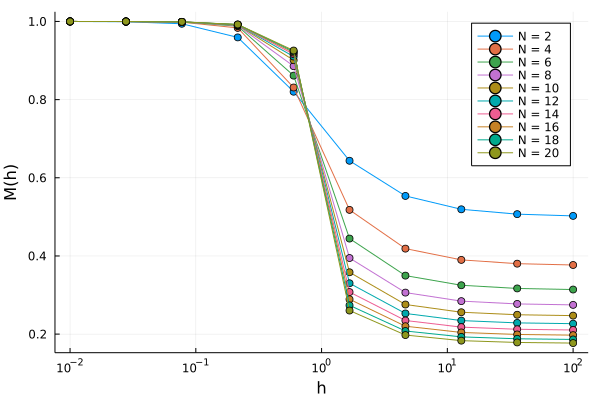

In [43]:
using Plots
hs = 10 .^ range(-2., stop=2., length=10)
Ns = 2:2:20
p = plot()
@time for N in Ns
    M = zeros(length(hs))
    for (i,h) in enumerate(hs)
        H = TransverseFieldIsing_sparse(N=N, h=h)
        vals, vecs = eigen_sparse(H)
        groundstate = @view vecs[:,1]
        M[i] = magnetization(groundstate)
    end
    plot!(p, hs, M, xscale=:log10, marker=:circle, label="N = $N",
        xlab="h", ylab="M(h)")
    println(M)
end
p